# Класифікація обʼєктів новобудови за текстовим описом за допомогою зворотної нейронної мережі

Рекурсивна нейронна мережа використовується для наборів даних які представляють собою серію послідовних даних. Наприклад, опис обʼєкту нерухомості є текстовою строкою. Кожний символ повʼязаний із попередніми символами та із наступними. Через це використання звичайної нейронної мережі є неможливим при роботі із текстом.

Натомість, для цього використовуються Рекурсивні Нейронні Мережі.

https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Dropout, TextVectorization, Embedding, LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
# BinaryCrossentropy функція повинна використовуватися для задач бінарної класифікації. Для мультикласової класифікації потрібно використовувати CategoricalCrossentropy
# from keras.losses import BinaryCrossentropy
from keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split

## Завантаження набору даних

### Ознайомлення з набором даних

In [18]:
df = pd.read_csv('./translated-1677270280197.csv', usecols=['residence', 'developer', 'price', 'attributes/class', 'description'])

In [19]:
df.head()

,residence,developer,attributes/class,description,price
0,ЖК Greenville на Печерську,Greenville,бізнес,Greenville is a combination of residential spa...,4138800.0
1,Linden Luxury Residences,Budhouse Group,преміум,The location of Linden Luxury Residences is th...,1709400.0
2,БФК OLEGIVSKIY,DIM,бізнес,OLEGIVSKIY is an exclusive business class mult...,3856325.0
3,ЖК Новий Автограф,DIM,комфорт,"Between both buildings of the ""New Autograph"" ...",3269700.0
4,NaN,NaN,NaN,NaN,NaN


In [20]:
df.sample()

,residence,developer,attributes/class,description,price
7,ЖК LUCKY LAND,DIM,комфорт,The Lucky Land residential complex is a new re...,1795500.0


In [21]:
df.shape

(100, 5)

### Фільтрація пустих значень

In [22]:
df = df.dropna(subset=['attributes/class', 'description'])

### Доступні в наборі даних класи нерухомості

In [23]:
df['attributes/class'].unique()

array(['бізнес', 'преміум', 'комфорт', 'економ'], dtype=object)

In [24]:
df.head()

,residence,developer,attributes/class,description,price
0,ЖК Greenville на Печерську,Greenville,бізнес,Greenville is a combination of residential spa...,4138800.0
1,Linden Luxury Residences,Budhouse Group,преміум,The location of Linden Luxury Residences is th...,1709400.0
2,БФК OLEGIVSKIY,DIM,бізнес,OLEGIVSKIY is an exclusive business class mult...,3856325.0
3,ЖК Новий Автограф,DIM,комфорт,"Between both buildings of the ""New Autograph"" ...",3269700.0
5,БФК А136 Highlight Tower,DIM,бізнес,Residential complex A136 Highlight Tower is a ...,6635250.0


### Переведення класів нерухомості до числових значень

In [25]:
class_to_num_map = { 'бізнес': 0, 'преміум': 1, 'комфорт': 2, 'економ': 3 }

df['class'] = df['attributes/class'].map(class_to_num_map)

In [26]:
df = df[['description', 'class']]

In [27]:
df.head()

,description,class
0,Greenville is a combination of residential spa...,0
1,The location of Linden Luxury Residences is th...,1
2,OLEGIVSKIY is an exclusive business class mult...,0
3,"Between both buildings of the ""New Autograph"" ...",2
5,Residential complex A136 Highlight Tower is a ...,0


## Підготовка даних для тренування моделі

### Створення сету характеристик і міток

TODO: використання imblearn.oversampling -> RandomOverSampler для прирівнювання к-сті зразків певного класу

In [28]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [29]:
train.shape, val.shape, test.shape

((70, 2), (9, 2), (9, 2))

In [30]:
df.head()

,description,class
0,Greenville is a combination of residential spa...,0
1,The location of Linden Luxury Residences is th...,1
2,OLEGIVSKIY is an exclusive business class mult...,0
3,"Between both buildings of the ""New Autograph"" ...",2
5,Residential complex A136 Highlight Tower is a ...,0


### Переведення міток до категоріальних значень

Так як мітки в даному випадку варіюються від 1 до 4 що вказує на певний клас будівлі, для того щоб повʼязати ці числа із виходом із softmax вихідного шару нейронної мережі, потрібно перевести числа до категоріального виду використовуюючи допоміжні функції keras.

In [31]:
x_train = train['description'].values
y_train = to_categorical(train['class'], 4)

x_valid = val['description'].values
y_valid = to_categorical(val['class'], 4)

x_test = test['description'].values
y_test = to_categorical(test['class'], 4)

x_pred = ['There is nothing good in this residential complex, please omit it']
y_pred = to_categorical([0], 4)

### Композиція моделі

In [32]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [33]:
model = Sequential()

model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [34]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [35]:
model.evaluate(x_train, y_train)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


3/3 [==============================] - 1s 4ms/step - loss: 1.4482 - accuracy: 0.1429


[1.44815194606781, 0.1428571492433548]

### Тренування моделі

Попередньо модель була натренована на 10-20 епохах, але цього було недостатньо. Після 10-20 епох точність моделі все ще зростає і модель не переходить в режим Overfitting

In [36]:
history = model.fit(x=x_train, y=y_train, epochs=30, validation_data=(x_valid, y_valid))

Epoch 1/30
3/3 [==============================] - 3s 833ms/step - loss: 1.4298 - accuracy: 0.1286 - val_loss: 1.3993 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 2s 739ms/step - loss: 1.3401 - accuracy: 0.1571 - val_loss: 1.3310 - val_accuracy: 0.1111
Epoch 3/30
3/3 [==============================] - 2s 728ms/step - loss: 1.2842 - accuracy: 0.3143 - val_loss: 1.2796 - val_accuracy: 0.3333
Epoch 4/30
3/3 [==============================] - 2s 771ms/step - loss: 1.2397 - accuracy: 0.5857 - val_loss: 1.2335 - val_accuracy: 0.5556
Epoch 5/30
3/3 [==============================] - 2s 724ms/step - loss: 1.1993 - accuracy: 0.6429 - val_loss: 1.1828 - val_accuracy: 0.7778
Epoch 6/30
3/3 [==============================] - 2s 766ms/step - loss: 1.1565 - accuracy: 0.6143 - val_loss: 1.1296 - val_accuracy: 0.7778
Epoch 7/30
3/3 [==============================] - 2s 814ms/step - loss: 1.1090 - accuracy: 0.6143 - val_loss: 1.0847 - val_accuracy: 0.7778
Epoch 8/30
3/3 [

### Результати тренування моделі

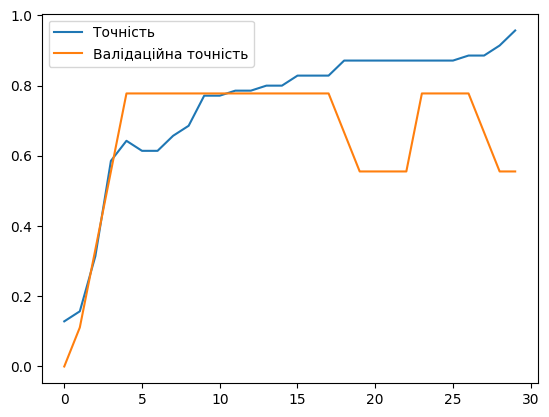

In [37]:
plt.plot(history.history['accuracy'], label="Точність")
plt.plot(history.history['val_accuracy'], label="Валідаційна точність")
plt.legend()

plt.show()

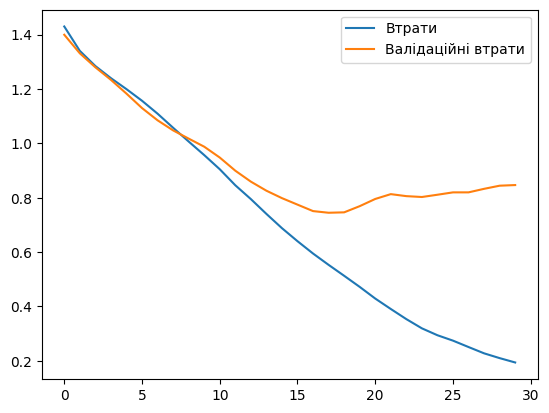

In [38]:
plt.plot(history.history['loss'], label="Втрати")
plt.plot(history.history['val_loss'], label="Валідаційні втрати")
plt.legend()

plt.show()

## Перевірка моделі на тестових даних яких раніше модель не бачила

In [39]:
def pred_to_text(pred):
    return list(class_to_num_map.keys())[list(class_to_num_map.values()).index(pred)]

In [40]:
pred_to_text(0), pred_to_text(1), pred_to_text(2), pred_to_text(3)

('бізнес', 'преміум', 'комфорт', 'економ')

In [41]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 157ms/step - loss: 0.8725 - accuracy: 0.8889


[0.8725433349609375, 0.8888888955116272]

In [42]:
pred = model.predict(x_pred)
pred_index = np.argmax(pred)

pred_to_text(pred_index)

1/1 [==============================] - 0s 241ms/step


'комфорт'

TODO: also use LSTM https://www.youtube.com/watch?v=VtRLrQ3Ev-U&ab_channel=freeCodeCamp.org

## LSTM модель

In [43]:
encoder = TextVectorization(max_tokens=2000)

In [44]:
x_train[0]

'Taryan Towers will become a new landmark of the capital thanks to its futuristic architecture and internal infrastructure. The three towers are connected from below by a common 4-story stylobate, and from above - by glass 2-story bridges. The lower covered part of the bridges will surround the three towers with a pedestrian zone with walking and jogging paths 370 meters long. Also, part of the sections of the floor of the bridge will be glass, so a walk along such sections will surely take your breath away. Taryan Towers are not twin towers: each building will have its own concept. In the first tower there will be an open panoramic restaurant with views of the capital, on the roof of the second tower there will be an open-air park with an artificial lake and a winter garden, and on the roof of the third tower there will be a cinema, a planetarium and a museum of the future. Infrastructure The concept of Taryan Towers infrastructure implies comfort and autonomy for residents: in the lo

In [45]:
encoder.adapt(x_train)

In [46]:
encoder.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'of',
 'a',
 'to',
 'in',
 'is',
 'complex',
 'with',
 'for',
 'are',
 'will',
 'minutes',
 'on',
 'be',
 'no',
 'residential',
 'you',
 'by',
 'from',
 'center',
 'can',
 'there',
 'which',
 'an',
 'area',
 'car',
 'infrastructure',
 'school',
 'apartments',
 'park',
 'sports',
 'new',
 'also',
 'walk',
 'or',
 'shopping',
 'city',
 'as',
 'residents',
 'fitness',
 'building',
 'it',
 'kyiv',
 'away',
 'territory',
 'located',
 'kindergarten',
 'house',
 'parking',
 'buildings',
 'at',
 'nearby',
 'childrens',
 'district',
 'where',
 'kindergartens',
 'within',
 'floors',
 'shops',
 '10',
 'near',
 'foot',
 'open',
 'its',
 'areas',
 'schools',
 'children',
 'project',
 'own',
 'metro',
 'first',
 'walking',
 'built',
 'not',
 'station',
 'club',
 'that',
 'have',
 'cars',
 'has',
 'drive',
 '—',
 'provided',
 'other',
 '15',
 'restaurants',
 'modern',
 'apartment',
 'two',
 'recreation',
 'one',
 'construction',
 'windows',
 'transport',
 'silpo',
 'ce

In [47]:
best_practice_lstm_output_dim = 32

model_lstm = Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=best_practice_lstm_output_dim, mask_zero=True),
    LSTM(best_practice_lstm_output_dim),
    Dense(units=best_practice_lstm_output_dim),
    Dense(units=4, activation="softmax")
])

In [48]:
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [49]:
model_lstm.evaluate(x_train, y_train)

3/3 [==============================] - 2s 30ms/step - loss: 1.3875 - accuracy: 0.2143


[1.3875043392181396, 0.2142857164144516]

In [50]:
history_lstm = model_lstm.fit(x=x_train, y=y_train, epochs=30, validation_data=(x_valid, y_valid))

Epoch 1/30
3/3 [==============================] - 3s 182ms/step - loss: 1.3842 - accuracy: 0.3143 - val_loss: 1.3591 - val_accuracy: 0.7778
Epoch 2/30
3/3 [==============================] - 1s 160ms/step - loss: 1.3626 - accuracy: 0.5571 - val_loss: 1.3284 - val_accuracy: 0.7778
Epoch 3/30
3/3 [==============================] - 1s 186ms/step - loss: 1.3418 - accuracy: 0.5571 - val_loss: 1.2908 - val_accuracy: 0.7778
Epoch 4/30
3/3 [==============================] - 1s 160ms/step - loss: 1.3139 - accuracy: 0.5571 - val_loss: 1.2440 - val_accuracy: 0.7778
Epoch 5/30
3/3 [==============================] - 1s 184ms/step - loss: 1.2782 - accuracy: 0.5571 - val_loss: 1.1717 - val_accuracy: 0.7778
Epoch 6/30
3/3 [==============================] - 0s 177ms/step - loss: 1.2304 - accuracy: 0.5571 - val_loss: 1.0460 - val_accuracy: 0.7778
Epoch 7/30
3/3 [==============================] - 1s 195ms/step - loss: 1.1492 - accuracy: 0.5571 - val_loss: 0.8219 - val_accuracy: 0.7778
Epoch 8/30
3/3 [====

In [51]:
model_lstm.evaluate(x_test, y_test)

1/1 [==============================] - 0s 59ms/step - loss: 0.7244 - accuracy: 0.6667


[0.7244042158126831, 0.6666666865348816]

TODO: створити новий набір даних із результатами роботи нейронної мережі і передати його на вхід до алгоритму лінійної регресії для оцінки вартості нерухомості